In [1]:
#---------------------------------------#
# author : https://github.com/vidit1999 #
#---------------------------------------#

In [2]:
# https://www.kaggle.com/andrewmvd/cyberbullying-classification

In [37]:
import re
import joblib
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from wordcloud import WordCloud
from sklearn import set_config
from IPython.core import pylabtools
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.utils import parallel_backend
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from lightgbm import LGBMClassifier

set_config(display='diagram')
pylabtools.figsize(16, 8)
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")
tqdm.pandas()

In [4]:
random.seed(0)
np.random.seed(0)

In [5]:
# !7z l "../Data/cyberbullying_tweets.zip"

In [6]:
# !7z x "../Data/cyberbullying_tweets.zip" -o"../Data"

In [7]:
df = pd.read_csv("../Data/cyberbullying_tweets.csv")

In [8]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [9]:
df.columns

Index(['tweet_text', 'cyberbullying_type'], dtype='object')

In [10]:
df.rename(columns={'tweet_text': 'tweet', 'cyberbullying_type': 'type'}, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   47692 non-null  object
 1   type    47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


<AxesSubplot:xlabel='count', ylabel='type'>

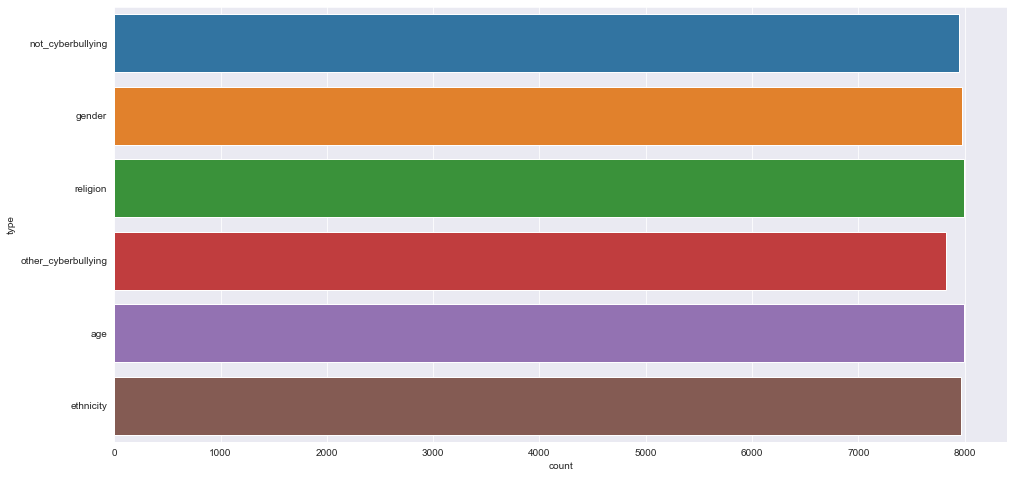

In [12]:
sns.countplot(y='type', data=df)

In [13]:
tag_map = defaultdict(
    lambda : "n",
    {
        'J' : "a",
        'V' : "v",
        'R' : "r",
    }
)

lemma = WordNetLemmatizer()
eng_stopwords = set(stopwords.words('english'))

In [14]:
def clean_sent(data):
    data = data.lower() # lowering
    data = data.encode("ascii", "ignore").decode() # non ascii chars
    data = re.sub(r'\n',' ', data) # remove new-line characters
    data = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', ' ', data) # remove html tags and entities
    data = data.replace(r'amp', ' ') # remove 'amp' word
    data = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', data, flags=re.MULTILINE) # to remove links that start with HTTP/HTTPS in the tweet
    data = re.sub(r'[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', data, flags=re.MULTILINE) # to remove other url links
    data = re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|(\w+:\/\/\S+)","",data) # mentions and hashtags
    data = re.sub(r'\W', ' ', data) # special chars
    data = re.sub(r'\s+[a-zA-Z]\s+', ' ', data) # single characters
    data = re.sub(r'\^[a-zA-Z]\s+', ' ', data) # single char at first
    data = re.sub(r'[0-9]', ' ', data) # digits
    data = re.sub(r'\s+', ' ', data, flags=re.I) # multiple spaces
    return ' '.join([
        lemma.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(word_tokenize(data))
        if token not in eng_stopwords
    ])

In [15]:
df['cleaned_tweet'] = df['tweet'].progress_apply(clean_sent)

  0%|          | 0/47692 [00:00<?, ?it/s]

In [16]:
df['clean_tweet_len'] = df['cleaned_tweet'].str.len()

In [17]:
df['clean_tweet_len'].describe()

count    47692.000000
mean        76.196700
std         52.537155
min          0.000000
25%         39.000000
50%         65.000000
75%        105.000000
max       2404.000000
Name: clean_tweet_len, dtype: float64

In [18]:
df = df[
    (df['clean_tweet_len'] <= np.quantile(df['clean_tweet_len'], q=.95)) &
    (np.quantile(df['clean_tweet_len'], q=.05) <= df['clean_tweet_len'])
]

<AxesSubplot:ylabel='Density'>

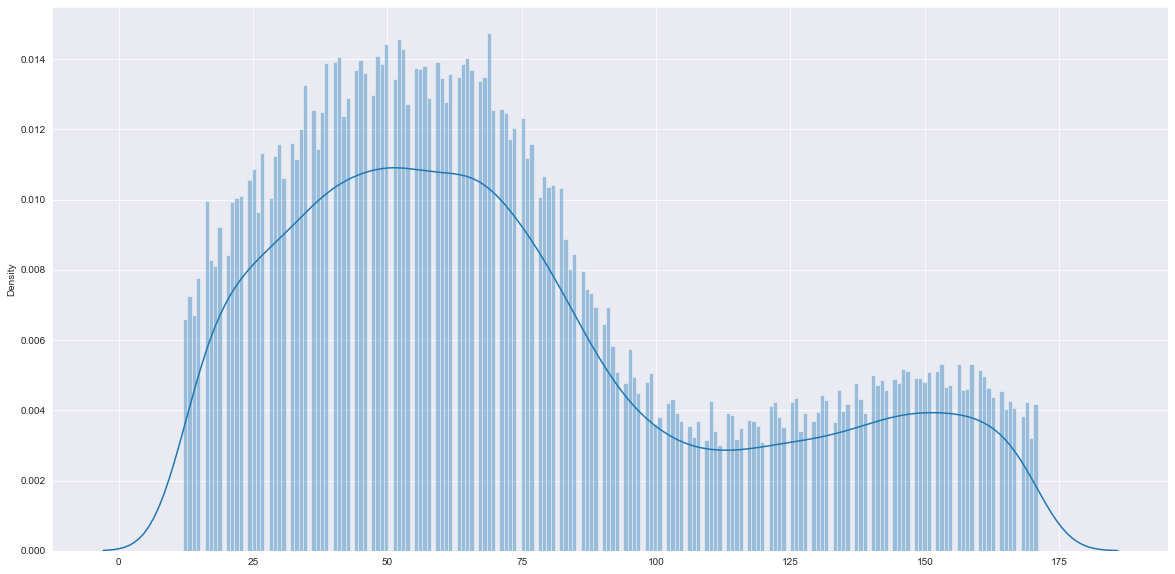

In [19]:
plt.figure(figsize=(20, 10))
sns.distplot(x=df['clean_tweet_len'], bins=200)

In [20]:
df['type'].value_counts()

ethnicity              7575
age                    7561
gender                 7381
not_cyberbullying      7107
religion               6874
other_cyberbullying    6674
Name: type, dtype: int64

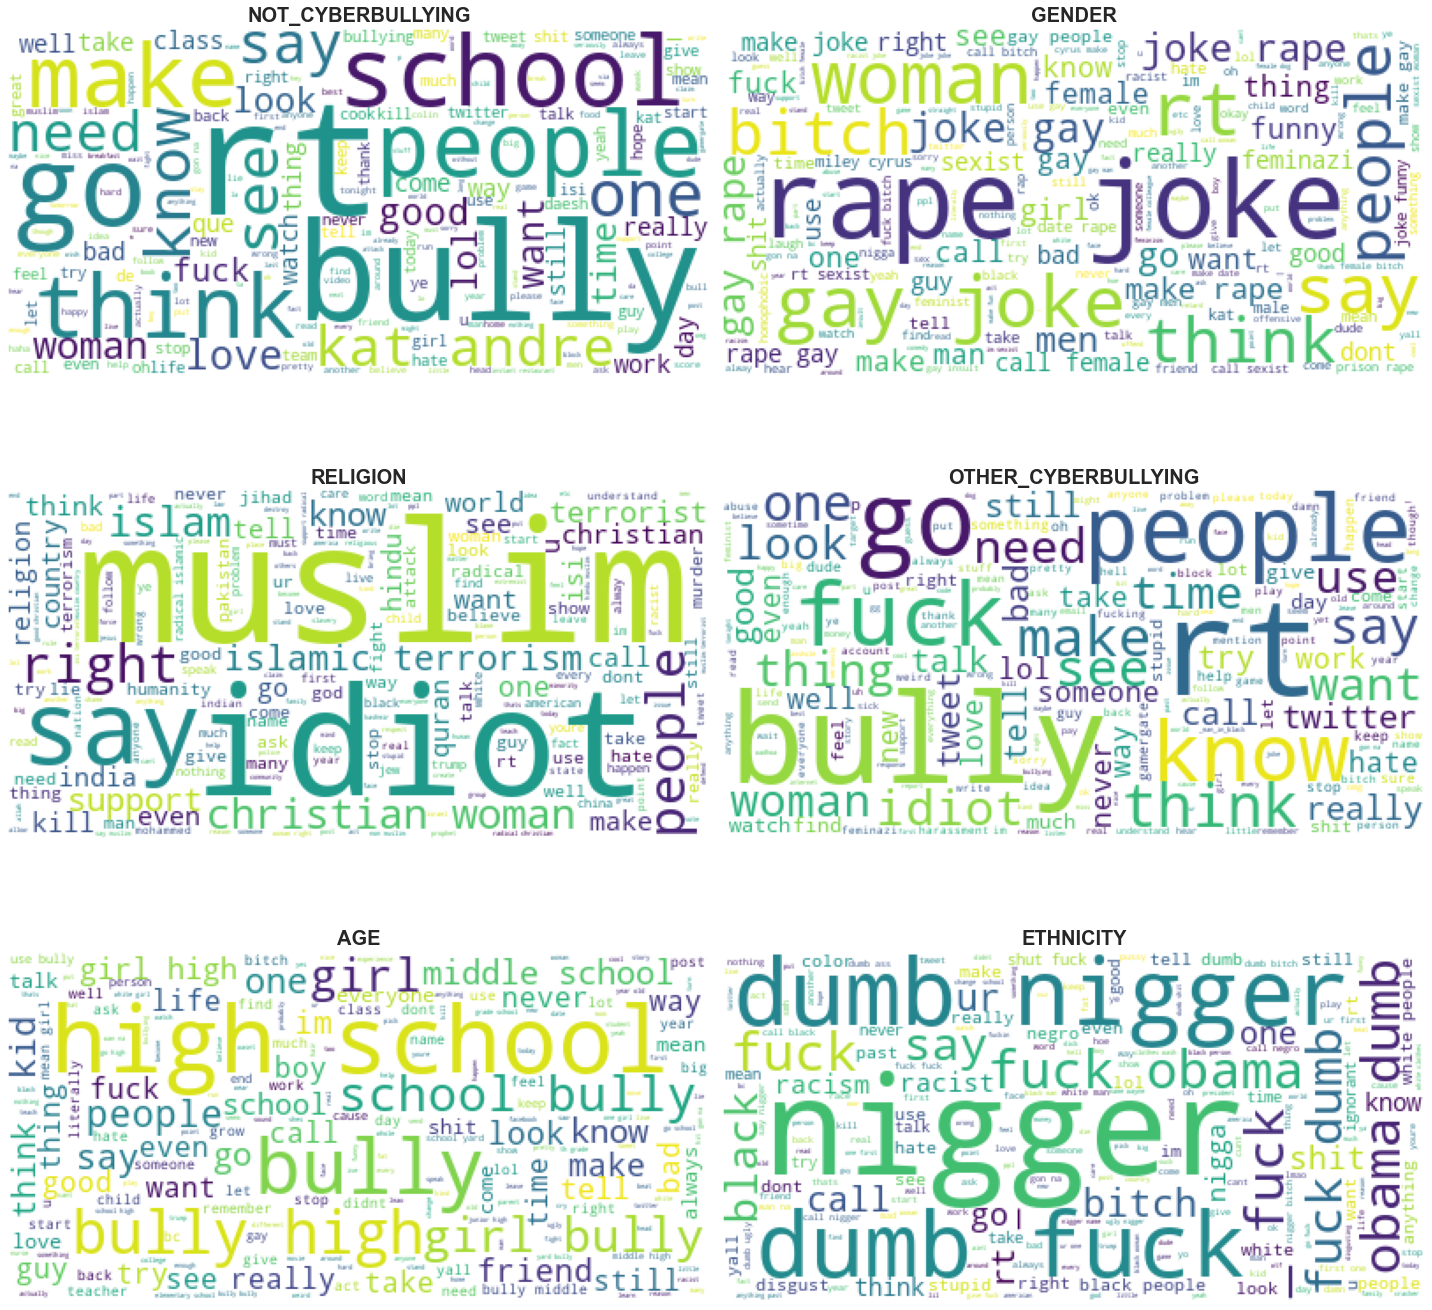

In [21]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

for i, tweet_type in enumerate(df['type'].unique()):
    ax = axs[i//2][i%2]
    
    wc = WordCloud(background_color='white').generate(' '.join(df[df['type'] == tweet_type]['cleaned_tweet']))
    
    ax.imshow(wc)
    ax.axis("off")
    ax.set_title(tweet_type.upper(), fontdict={'fontsize': 20, 'fontweight': 'bold'})
fig.tight_layout()

In [22]:
df = df[df['type'] != 'other_cyberbullying']

In [23]:
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

In [24]:
pd.DataFrame({
    "type": le.classes_,
    "type_encoded": le.transform(le.classes_)
})

,type,type_encoded
0,age,0
1,ethnicity,1
2,gender,2
3,not_cyberbullying,3
4,religion,4


In [25]:
df

,tweet,type,cleaned_tweet,clean_tweet_len,type_encoded
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word food crapilicious,22,3
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake,31,3
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,_gio meh thanks head concern another angry dud...,55,3
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account like islam...,50,3
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying,yes test god good bad indifferent weird whatev...,68,3
...,...,...,...,...,...
47686,@YourFavWhiteGuy shut the fuck upAbout your du...,ethnicity,shut fuck upabout dumb app act like nag nigger,46,1
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,black ppl expect anything depend anything yet ...,137,1
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,swear god dumb nigger bitch get bleach hair re...,69,1
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,yea fuck rt youre nigger fuck unfollow fuck du...,55,1


In [26]:
df['type_encoded'].value_counts()

1    7575
0    7561
2    7381
3    7107
4    6874
Name: type_encoded, dtype: int64

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df[["cleaned_tweet", "clean_tweet_len"]], df['type_encoded'])

In [28]:
print(X_train.shape)
print(X_test.shape)

(27373, 2)
(9125, 2)


In [29]:
pipeline = Pipeline([
    (
        "selector",
        ColumnTransformer([
            (
                "selector",
                "passthrough",
                ["cleaned_tweet", "clean_tweet_len"]
            )
        ])
    ),
    (
        "transform",
        ColumnTransformer(
            [
                (
                    "text_feature",
                    Pipeline([
                        ("tfidf", TfidfVectorizer()),
                        ("tsvd", TruncatedSVD(n_components=25)),
                    ]),
                    0
                ),
                (
                    "minmax_scale",
                    MinMaxScaler(),
                    [1]
                )
            ],
            remainder="drop",
        )
    ),
    ("smote", SMOTE()),
    ("model", LGBMClassifier())
])

pipeline

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['cleaned_tweet',
                                                   'clean_tweet_len'])])),
                ('transform',
                 ColumnTransformer(transformers=[('text_feature',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('tsvd',
                                                                   TruncatedSVD(n_components=25))]),
                                                  0),
                                                 ('minmax_scale',
                                                  MinMaxScaler(), [1])])),
                ('smote', SMOTE()), ('model', LGBMClassifier())])

In [31]:
train_spaces=np.linspace(0.1, 1, 10)

train_sizes, train_scores, test_scores = learning_curve(
    pipeline,
    X_train, y_train,
    train_sizes=train_spaces,
    n_jobs=-1,
    verbose=2
)

[learning_curve] Training set sizes: [ 2189  4379  6569  8759 10949 13138 15328 17518 19708 21898]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:   58.9s remaining:   58.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


[Text(0.5, 0, 'Sizes'),
 Text(0, 0.5, 'Scores'),
 Text(0.5, 1.0, 'Model Learing Curve')]

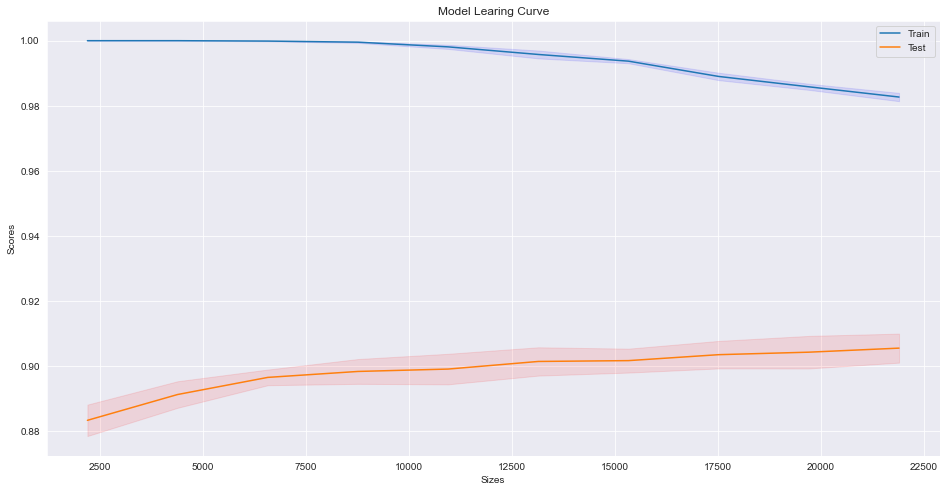

In [32]:
# mean scores and std
train_score_mean = np.mean(train_scores, axis=1)
test_score_mean = np.mean(test_scores, axis=1)
train_score_std = np.std(train_scores, axis=1)
test_score_std = np.std(test_scores, axis=1)


# train score and confidence interval
ax = sns.lineplot(x=train_sizes, y=train_score_mean, label='Train')
ax.fill_between(
    train_sizes,
    train_score_mean - train_score_std,
    train_score_mean + train_score_std,
    alpha=0.1,
    color="b",
)

# test score and confidence interval
sns.lineplot(x=train_sizes, y=test_score_mean, label='Test', ax=ax)
ax.fill_between(
    train_sizes,
    test_score_mean - test_score_std,
    test_score_mean + test_score_std,
    alpha=0.1,
    color="r",
)

ax.set(xlabel="Sizes", ylabel="Scores", title="Model Learing Curve")

In [38]:
param_grid = {
    'transform__text_feature__tfidf__ngram_range': [(1, 1), (1, 2)],
    'model__importance_type': ['split', 'gain'],
    'model__n_estimators': [100, 200, 300],
}

In [39]:
gscv = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=2
).fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [40]:
gscv.best_params_

{'model__importance_type': 'split',
 'model__n_estimators': 200,
 'transform__text_feature__tfidf__ngram_range': (1, 1)}

In [41]:
pd.DataFrame(gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__importance_type,param_model__n_estimators,param_transform__text_feature__tfidf__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,13.193947,0.243037,0.513817,0.051672,split,100,"(1, 1)","{'model__importance_type': 'split', 'model__n_...",0.906849,0.895525,0.908128,0.906650,0.904092,0.904249,0.004554,6
1,19.738241,1.383262,0.684211,0.050764,split,100,"(1, 2)","{'model__importance_type': 'split', 'model__n_...",0.902100,0.892968,0.905388,0.894775,0.897881,0.898623,0.004587,10
2,18.391066,0.408145,1.516847,0.198702,split,200,"(1, 1)","{'model__importance_type': 'split', 'model__n_...",0.909954,0.896621,0.909589,0.906832,0.905554,0.905710,0.004836,1
3,24.787175,0.502370,1.792539,0.430988,split,200,"(1, 2)","{'model__importance_type': 'split', 'model__n_...",0.902100,0.890776,0.903014,0.900986,0.896785,0.898732,0.004513,9
4,23.051134,0.332045,3.191444,0.831106,split,300,"(1, 1)","{'model__importance_type': 'split', 'model__n_...",0.913059,0.897900,0.907945,0.904640,0.903544,0.905418,0.005008,3
5,30.398680,0.944612,2.952584,0.429129,split,300,"(1, 2)","{'model__importance_type': 'split', 'model__n_...",0.902466,0.895525,0.902831,0.898977,0.897881,0.899536,0.002778,7
6,11.806716,0.457153,0.503486,0.068283,gain,100,"(1, 1)","{'model__importance_type': 'gain', 'model__n_e...",0.909224,0.897169,0.907945,0.905919,0.904823,0.905016,0.004212,4
7,19.629577,1.219193,0.738402,0.080683,gain,100,"(1, 2)","{'model__importance_type': 'gain', 'model__n_e...",0.898630,0.888950,0.900822,0.895323,0.898612,0.896467,0.004149,12
8,18.011964,0.237324,1.296568,0.208882,gain,200,"(1, 1)","{'model__importance_type': 'gain', 'model__n_e...",0.908676,0.897352,0.911233,0.906102,0.900073,0.904687,0.005213,5
9,24.197455,0.618299,1.609292,0.336348,gain,200,"(1, 2)","{'model__importance_type': 'gain', 'model__n_e...",0.900639,0.891507,0.902466,0.897698,0.898429,0.898148,0.003721,11


In [42]:
best_model = gscv.best_estimator_

In [43]:
y_pred = best_model.predict(X_test)

In [65]:
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))

                   precision    recall  f1-score   support

              age     0.9786    0.9770    0.9778      1916
        ethnicity     0.9839    0.9724    0.9781      1887
           gender     0.9034    0.8049    0.8513      1835
not_cyberbullying     0.7442    0.8477    0.7926      1733
         religion     0.9396    0.9310    0.9353      1754

         accuracy                         0.9081      9125
        macro avg     0.9099    0.9066    0.9070      9125
     weighted avg     0.9125    0.9081    0.9091      9125



In [66]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

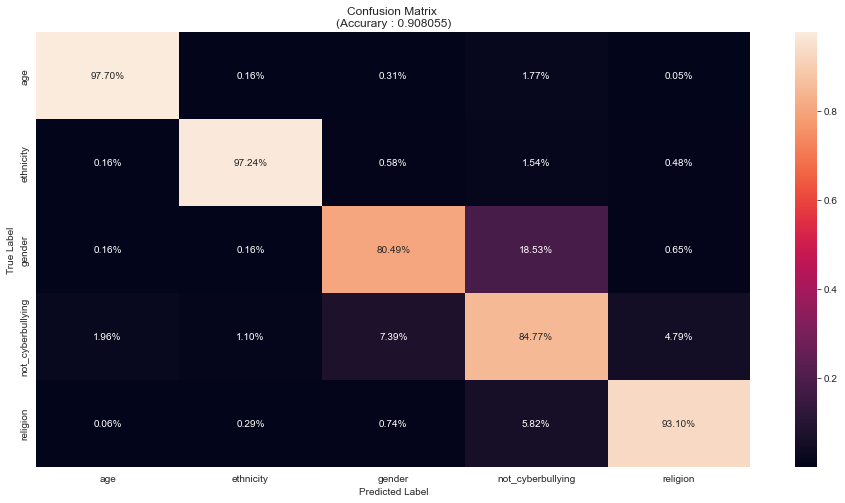

In [67]:
ax = sns.heatmap(cm, annot=True, xticklabels=le.classes_, yticklabels=le.classes_, fmt=".2%")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

ax.set_title(f"Confusion Matrix \n(Accurary : {accuracy_score(y_test, y_pred):.6f})")

plt.show()

In [68]:
joblib.dump(best_model, "../Data/Cyber Bullying Classification.pkl")

['../Data/Cyber Bullying Classification.pkl']